# Exemple de Linearized LoadFlow avec pyomo

Dans cet exemple, on présente les étapes et les outils développés dans lms2 pour réaliser l'optimistion d'un LinDistFlow. 
Pour rappel, le LinDistFlow est une approximation linéaire pour les réseaux de distribution radiaux. C'ette implémentation modélise un réseau triphasé déséquilibré provenant de  E. Stewart, « A Linearized Power Flow Model for Optimization in Unbalanced Distribution Systems », 2016

Dans cet exemple, 
    
    1. On crée un graphe fictif avec une structure de donnée particulière
    2.  
        - On instancie le problème d'optimisation, en utilisant la fonction `network_3phases_lindistflow`, qui prend en entrée le graphe puis définit variablses et paraètres en conséquence. 
        - On initialise les conditions limites. Ici, il s'agit principalement de charger les profils d'injection de puissance active et réactive en chaque noeud du graphe. 
    3. On résout le problème
    4. On récupère les valeurs de tensions à chaque noeud pour les afficher dans un graphe. Puis on enregistre le graphe au format json. 

## 1. Creating network and data structure

Dans cette partie, on crée un graphe de données en utilsant la bibliothèque networkx. Les noeuds du graphe sont des noeuds électriques triphasés. Les branches sont des connexions triphasées. Les données du graphe sont utilisées pour enregistrer des grandeurs du type longeur, résistance linéïque, etc. 

On commence par définir un type de câble. (ce serait bien d'avoir une base de donnée de câbles dans laquelle on puisse choisir...)

In [24]:
from sphinx.ext.graphviz import graphviz

from lms2.electric.network import Cable
import numpy as np

cable_3_150_95 = Cable(name  = 'cable_3_150_95',
                       doc   = 'Cable triphasé de section 150 mm²',
                       type  = 'triphasé 3 fils',
                       r     = np.array([[0.3953, 0.1834, 0.1908], [0.1834, 0.3809, 0.1834], [0.1908, 0.1834, 0.3953]]),
                       x     = np.array([[0.1602, 0.1216, 0.0844], [0.1216, 0.2067, 0.1216], [0.0844, 0.1216, 0.1602]]),
                       v_nom = 230,
                       s_nom = 250/3)

On peut maintenant créer un graphe qui contiendra les nœuds, les branches et des données du type : longueurs, et type de conducteurs. Ça peut paraître un peu lourd de définir un conducteur par branche, mais c'est ce qu'il y a de plus générique. Pour un réseau plus grand, c'est facilement réalisable avec une boucle sur les branches. On pourrait par la suite imaginer représenter le transfo par un type de branche différent.

In [25]:
import networkx as nx

edges = [(0, 1, {'length': 10, 'cable': cable_3_150_95}),
         (1, 2, {'length': 20, 'cable': cable_3_150_95}),
         (2, 3, {'length': 20, 'cable': cable_3_150_95}),
         (1, 4, {'length': 20, 'cable': cable_3_150_95})]

g = nx.from_edgelist(edges, create_using=nx.DiGraph())


Pour simplifier l'écriture des équations du modèle DistFlow, on calcule les matrices notées R et X qui interviennent dans l'équation du modèle, telles que :  


$V_j^2 = V_i^2 - 2(RP_{ij}+XQ_{ij})$

Pour chaque noeud du graphe, on ajoute une donnée `fix_p_out=True/False` et `fix_q_out=True/False`. À noter que ce sont des vecteurs de taille de la même taille que `phases`.  

Ce qui permet, à la création du modèle d'optimisation, d'instantier une variable et de fixer ou non ses valeurs. On ajoute des valeurs nominales de p_out et q_out pour l'initialisation (seulement effectif si le profil est fixé). Si fix_p_out d'une phase est False, on regarde s'il y a des bornes p_out_max, p_out_min, q_out_max, q_out_min.

Pour l'exemple, on fixe les profils de tous les nœuds, sauf le 3eme, phase c.  


In [26]:
import random


for n in g.nodes():
    g.nodes[n]['p_out_min'] = (-1e3, -1e3, -1e3)
    g.nodes[n]['p_out_max'] = (1e3, 1e3, 1e3)
    g.nodes[n]['q_out_min'] = (-1e3, -1e3, -1e3)
    g.nodes[n]['q_out_max'] = (1e3, 1e3, 1e3)

for n in [0, 1, 2, 4]:
    g.nodes[n]['fix_p_out'] = (True, True, True)
    g.nodes[n]['fix_q_out'] = (True, True, True)
    liste = [0] * 3
    liste[random.randint(0, 2)] = 20
    g.nodes[n]['p_out'] = liste
    g.nodes[n]['q_out'] = (0, 0, 0)

# On libère l'injection de puissance active sur la phase c du noeud 3 :
g.nodes[3]['fix_p_out'] = (True, True, False)
g.nodes[3]['fix_q_out'] = (True, True, False)


print('Q_out is fixed ? : ', {node : data['fix_q_out'] for node, data in g.nodes(data=True)})
print('P_out is fixed ? : ', {node : data['fix_p_out'] for node, data in g.nodes(data=True)})

Q_out is fixed ? :  {0: (True, True, True), 1: (True, True, True), 2: (True, True, True), 3: (True, True, False), 4: (True, True, True)}
P_out is fixed ? :  {0: (True, True, True), 1: (True, True, True), 2: (True, True, True), 3: (True, True, False), 4: (True, True, True)}


In [27]:
from lms2.electric.graph_utils import calc_edge_pq_matrix

calc_edge_pq_matrix(g)

## 2. Création du problème d'optimisation simple

### 1. Instantiation du problème 

On instancie un modèle vide, on définit un horizon temporel d'un jour et on utilise le graphe précédemment généré pour instancié le problème de LoadFlow, sous forme d'un bloc Pyomo.

In [28]:
from pyomo.environ import *

m = ConcreteModel()

from lms2.core.horizon import SimpleHorizon
from lms2.electric.network import network_3phases_lindistflow

horizon = SimpleHorizon(tstart='2024-01-01 00:00:00', tend='2024-01-01 01:00:00', time_step='15min')
m.time = Set(initialize=horizon.index)
m.dist = Block(rule=lambda b: network_3phases_lindistflow(b, **{'time': m.time, 'graph': g}))

### 2. Chargement des données

Si les données sont indexées par une colonne en seconde. L'unité utilisée peut-être renseignée (par défaut 's'), la zone peut être renseignée (défaut : Europe/Paris), et la date de début des données doit être renseignée. Cet index est ensuite automatiquement transformé en date.

Pour l'exemple, on fixe le profile de puissance active au noeud 1, phase acomme étant le profile 2 du fichier csv `inputs_P_Q_HTA.csv`.
 

In [29]:
from lms2.tools.data_processing import read_data, load_data
import os

data_P = read_data(horizon, os.path.join(os.getcwd(), 'data', 'inputs_P_Q_HTA.csv'),
                        usecols=[0, 1, 2, 3],
                        unit='s',
                        start_date='2024-01-01 00:00:00')

data_P.head(5)

,profil_1,profil_2,profil_3,time (s)
2024-01-01 00:00:00+01:00,10.0,5.0,-5.0,0.0
2024-01-01 00:15:00+01:00,10.0,5.0,-5.0,900.0
2024-01-01 00:30:00+01:00,10.0,10.0,-5.0,1800.0
2024-01-01 00:45:00+01:00,10.0,10.0,-5.0,2700.0
2024-01-01 01:00:00+01:00,10.0,10.0,-5.0,3600.0


In [30]:
load_data(horizon, m.dist.p_out[1, 0, :], data_P['profil_2'], time_index_position=2)

Vérifions que l'initialisation de p_out a bien fonctionné en affichant le résultat du prettyprint. On vérifie que les valeurs sont bien celles définies dans le fichier csv. À note que si les index de l'horizon temporel et du fichier csv ne sont pas identiques, la fonction `load_data` fait une interpolation lineaire. 
On vérifie aussi que seules les variables des index (3,2,:), soit le nœud 3, phase 'c', ne sont pas fixés.

In [31]:
m.dist.p_out.pprint()

p_out : active power injection in kW
    Size=75, Index=dist.p_out_index, Units=kW
    Key            : Lower   : Value : Upper  : Fixed : Stale : Domain
       (0, 0, 0.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
     (0, 0, 900.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
    (0, 0, 1800.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
    (0, 0, 2700.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
    (0, 0, 3600.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
       (0, 1, 0.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
     (0, 1, 900.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
    (0, 1, 1800.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
    (0, 1, 2700.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
    (0, 1, 3600.0) : -1000.0 :     0 : 1000.0 :  True : False :  Reals
       (0, 2, 0.0) : -1000.0 :    20 : 1000.0 :  True : False :  Reals
     (0, 2, 900.0) : -1000.0 :    20 : 1000.0 :  True : False :  

### 3. Résolution du problème d'optimisation 
Pour l'exemple, on fixe l'objectif à une constante et on résout le loadflow. 

In [32]:
m.obj = Objective(expr=0)
#sol = SolverFactory('gurobi', solver_io="direct")
sol = SolverFactory('glpk')
res = sol.solve(m)

import matplotlib.pyplot as plt
import pandas as pd

    solver failure.


### 4. Post Processing

In [33]:
y = m.dist.y.get_values()
v = [[[np.sqrt(y[(i, j, k)]) for k in horizon.index] for j in [0, 1, 2]] for i in m.dist.graph.nodes]

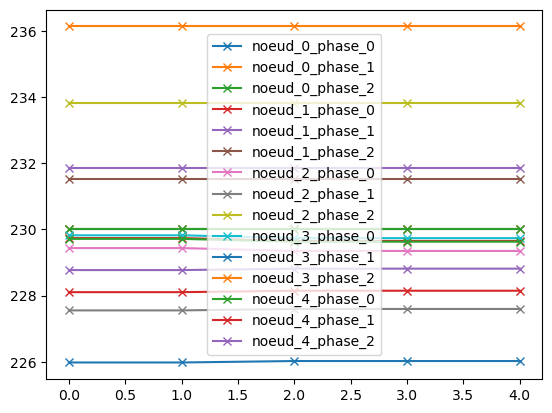

In [34]:
plt.figure()
for i in m.dist.graph.nodes():
    for j in [0, 1, 2]:
        plt.plot(v[i][j], marker='x', label=f'noeud_{i}_phase_{j}')
        
plt.legend()

In [35]:
graph = m.dist.graph.copy()
graph.edges(data=True)

for n1 in graph.nodes():
    graph.nodes[n1]['p_out'] = [[m.dist.p_out[n1, phase, t]() for t in horizon.index] for phase in m.dist.phases]
    graph.nodes[n1]['q_out'] = [[m.dist.q_out[n1, phase, t]() for t in horizon.index] for phase in m.dist.phases]
    graph.nodes[n1]['v'] = [[np.sqrt(m.dist.y[n1, phase, t]()) for t in horizon.index] for phase in m.dist.phases]
    
for n1, n2 in graph.edges():
    graph.edges[n1, n2]['p'] = [[m.dist.p[(n1, n2), phase, t]() for t in horizon.index] for phase in m.dist.phases]
    graph.edges[n1, n2]['q'] = [[m.dist.q[(n1, n2), phase, t]() for t in horizon.index] for phase in m.dist.phases]
    
from lms2.electric.graph_utils import save_json_graph, read_json_graph
save_json_graph(graph, os.path.realpath('data/network_graph_results.json'))

### 3. Example of saving/laoding graph



from lms2.electric.graph_utils import save_json_graph, read_json_graph
import os

save_json_graph(g, os.path.realpath('data/test.json'))
g2 = read_json_graph(os.path.realpath('data/test.json'))


### 4. Example of changing edge parameter


branche = (1, 2)

new_cable = Cable(name  = 'new',
                       doc   = 'Cable triphasé de section 150 mm²',
                       type  = 'triphasé 3 fils',
                       r     = np.array([[0.3, 0.2, 0.2], [0.2, 0.3, 0.2], [0.2, 0.2, 0.3]]),
                       x     = np.array([[0.15, 0.12, 0.08], [0.12, 0.20, 0.12], [0.08, 0.12, 0.15]]),
                       v_nom = 230,
                       s_nom = 200/3)

g.edges[branche].update({'cable': new_cable})